# CDS Data Exploration

This notebook explores CDS index data from Bloomberg and performs initial data quality checks.

In [1]:
# Setup
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set plotting style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Import our modules
from src.data import BloombergCDSConnector, CDSDataManager
from src.models import Region, Market, Tenor, CDSDatabase

print('Modules imported successfully')

Modules imported successfully


## 1. Initialize Connections

In [42]:
# Initialize Bloomberg connector
connector = BloombergCDSConnector()

# Initialize database
db = CDSDatabase('../data/cds_monitor.db')

# Initialize data manager
manager = CDSDataManager(connector, db)

print('Connections initialized')
print(f'Database location: {db.db_path}')

Connections initialized
Database location: ..\data\cds_monitor.db


In [43]:
db.close()

## 2. Test Bloomberg Connection

In [3]:
# Test with a single index
test_ticker = connector.get_index_ticker('EU', 'IG', 43, '5Y')
print(f'Test ticker: {test_ticker}')

# Fetch current spread
try:
    spread_data = connector.get_current_spread(test_ticker)
    if not spread_data.empty:
        print('\nCurrent market data:')
        print(spread_data.T)
    else:
        print('No data returned - check Bloomberg connection')
except Exception as e:
    print(f'Error fetching data: {e}')
    print('Make sure Bloomberg Terminal is running and logged in')

Test ticker: ITRX EUR CDSI S43 5Y

Current market data:
           ITRX EUR CDSI S43 5Y CBIN INDEX
px_last                            50.6583
px_bid                            50.44558
px_ask                            50.87102
chg_net_1d                         0.61175
chg_pct_1d                        1.222362
time                              15:16:44


## 3. Load Main Indices (ITXEB and ITXEX)

In [4]:
# Load main indices tracked in Excel
print('Loading main indices (EU and US)...')
main_indices = manager.load_main_indices(save_to_db=True)

if not main_indices.empty:
    print(f'\nLoaded {len(main_indices)} indices')
    
    # Group by region and market to see what was loaded
    summary = main_indices.groupby(['region', 'market', 'series'])['tenor'].count().unstack(fill_value=0)
    print('\nLoaded indices summary:')
    print(summary)
    
    print('\nSample data:')
    print(main_indices.head(10))
else:
    print('No data loaded - check Bloomberg connection')

Loading main indices (EU and US)...

Loaded 16 indices

Loaded indices summary:
series         40  41  42  43
region market                
EU     IG       4   4   4   4

Sample data:
    px_last    px_bid    px_ask chg_net_1d chg_pct_1d      time region market  \
0  10.68294  8.702027  12.66386    0.50568   4.968724  15:16:45     EU     IG   
1  34.08205  32.69398  35.47013    0.33873   1.003843  15:16:44     EU     IG   
2  57.58841  56.75401   58.4228    1.25906   2.235176  15:16:45     EU     IG   
3  84.30245  81.90876  86.69614   -1.97248  -2.286273  15:16:44     EU     IG   
4  15.72043  14.30829  17.13257    0.30263   1.962861  15:16:44     EU     IG   
5  39.30261   38.1212  40.48402    0.47521   1.223904  15:16:44     EU     IG   
6   61.5624  60.23503  62.88978    1.03985    1.71812  15:16:44     EU     IG   
7  85.88756  84.37299  87.40213   -2.14397  -2.435457  15:16:44     EU     IG   
8  21.66701  20.56922   22.7648    0.26578   1.241891  15:16:45     EU     IG   
9   45

## 4. Analyze Current Spreads

In [5]:
# Dynamically get current series
from datetime import datetime

def get_current_series():
    today = datetime.now()
    ref_date = datetime(2025, 3, 20)
    eu_series = 43
    months_diff = (today.year - ref_date.year) * 12 + today.month - ref_date.month
    if today.day < 20:
        months_diff -= 1
    return eu_series + (months_diff // 6)

current_series = get_current_series()
print(f'Current on-the-run series: {current_series}')

# Rest of the cell remains the same

Current on-the-run series: 43


## 5. Build Credit Curves

In [6]:
# Build IG curve for current series
print(f'Building curve for EU IG S{current_series}...')

try:
    curve = manager.build_curve(
        region=Region.EU,
        market=Market.IG,
        series=current_series,
        save_to_db=True
    )

    if curve:
        # Display curve
        curve_df = curve.to_dataframe()
        print('\nTerm Structure:')
        print(curve_df[['tenor', 'spread', 'dv01']])
        
        # Check if we have the required columns
        required_cols = ['years', 'spread']
        if not all(col in curve_df.columns for col in required_cols):
            print(f"Warning: Missing required columns. Available columns: {list(curve_df.columns)}")
            # Try alternative column names
            if 'maturity' in curve_df.columns:
                curve_df['years'] = curve_df['maturity']
            elif 'tenor_years' in curve_df.columns:
                curve_df['years'] = curve_df['tenor_years']
        
        # Plot curve
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(curve_df['years'], curve_df['spread'], 'o-', color='blue', linewidth=2, markersize=6)
        plt.xlabel('Years')
        plt.ylabel('Spread (bps)')
        plt.title(f'EU IG S{current_series} Credit Curve')
        plt.grid(True, alpha=0.3)
        
        # Calculate slopes - with error handling
        try:
            slopes = {
                '3s5s': curve.get_slope(Tenor.Y3, Tenor.Y5),
                '5s7s': curve.get_slope(Tenor.Y5, Tenor.Y7),
                '5s10s': curve.get_slope(Tenor.Y5, Tenor.Y10),
                '7s10s': curve.get_slope(Tenor.Y7, Tenor.Y10)
            }
            
            # Filter out None values
            slopes = {k: v for k, v in slopes.items() if v is not None and not np.isnan(v)}
            
            if slopes:
                plt.subplot(1, 2, 2)
                bars = plt.bar(slopes.keys(), slopes.values(), 
                              color=['green' if v > 0 else 'red' for v in slopes.values()],
                              alpha=0.7)
                plt.xlabel('Slope')
                plt.ylabel('Basis Points')
                plt.title('Curve Slopes')
                plt.grid(True, axis='y', alpha=0.3)
                plt.xticks(rotation=45)
                
                # Add value labels on bars
                for bar, value in zip(bars, slopes.values()):
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height + (1 if height >= 0 else -3),
                            f'{value:.1f}', ha='center', va='bottom' if height >= 0 else 'top')
            else:
                plt.subplot(1, 2, 2)
                plt.text(0.5, 0.5, 'No slope data available', 
                        transform=plt.gca().transAxes, ha='center', va='center')
                plt.title('Curve Slopes - No Data')
        
        except Exception as slope_error:
            print(f"Warning: Could not calculate slopes: {slope_error}")
            plt.subplot(1, 2, 2)
            plt.text(0.5, 0.5, f'Slope calculation failed:\n{str(slope_error)}', 
                    transform=plt.gca().transAxes, ha='center', va='center')
            plt.title('Curve Slopes - Error')
            slopes = {}
        
        plt.tight_layout()
        plt.show()
        
        # Display slopes if available
        if 'slopes' in locals() and slopes:
            print('\nSlopes:')
            for name, value in slopes.items():
                print(f'{name}: {value:.2f} bps')
        else:
            print('\nNo slope data available')
            
    else:
        print("❌ Failed to build curve - no curve object returned")
        print("This could be due to:")
        print("- Bloomberg connection issues")
        print("- Missing data for the requested series")
        print("- Database connection problems")
        
except Exception as e:
    print(f"❌ Error building curve: {str(e)}")
    print(f"Error type: {type(e).__name__}")
    
    # Additional debugging info
    print("\nDebugging info:")
    print(f"- Current series: {current_series}")
    print(f"- Manager initialized: {manager is not None}")
    print(f"- Region.EU: {Region.EU}")
    print(f"- Market.IG: {Market.IG}")

Error processing tenor 3Y: '3Y' is not a valid Tenor
Error processing tenor 5Y: '5Y' is not a valid Tenor
Error processing tenor 7Y: '7Y' is not a valid Tenor
Error processing tenor 10Y: '10Y' is not a valid Tenor


Building curve for EU IG S43...

Term Structure:
❌ Error building curve: "['dv01'] not in index"
Error type: KeyError

Debugging info:
- Current series: 43
- Manager initialized: True
- Region.EU: Region.EU
- Market.IG: Market.IG


In [7]:
# Debug: Check what columns are in the spread DataFrame
ticker = connector.get_index_ticker('EU', 'IG', current_series, '5Y')
spread = connector.get_current_spread(ticker)
print(f"Columns in spread DataFrame: {spread.columns.tolist()}")
print(f"Spread data:\n{spread}")

Columns in spread DataFrame: ['px_last', 'px_bid', 'px_ask', 'chg_net_1d', 'chg_pct_1d', 'time']
Spread data:
                                 px_last    px_bid    px_ask chg_net_1d  \
ITRX EUR CDSI S43 5Y CBIN INDEX  50.6583  50.44558  50.87102    0.61175   

                                chg_pct_1d      time  
ITRX EUR CDSI S43 5Y CBIN INDEX   1.222362  15:16:44  


Term Structure:
3Y: 27.43 bps
5Y: 50.66 bps
7Y: 70.54 bps
10Y: 91.93 bps


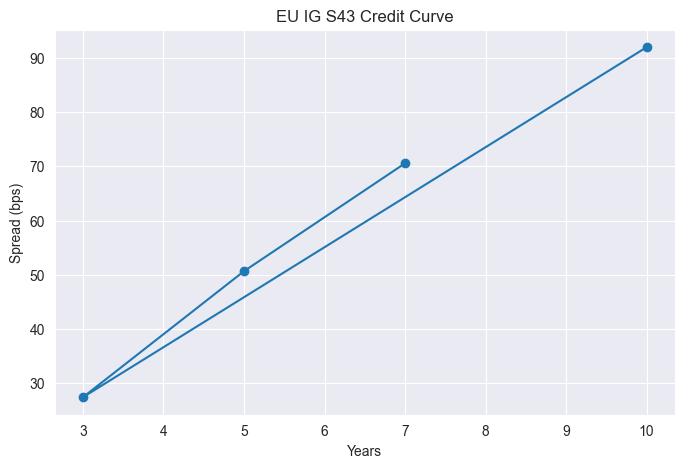

In [8]:
# Build curve from main_indices data
current_curve_data = main_indices[(main_indices['region'] == 'EU') & 
                                  (main_indices['market'] == 'IG') & 
                                  (main_indices['series'] == current_series)]

if not current_curve_data.empty:
    print("Term Structure:")
    for _, row in current_curve_data.iterrows():
        print(f"{row['tenor']}: {row['px_last']:.2f} bps")
    
    # Create simple plot
    curve_data_sorted = current_curve_data.sort_values('tenor')
    tenor_map = {'3Y': 3, '5Y': 5, '7Y': 7, '10Y': 10}
    curve_data_sorted['years'] = curve_data_sorted['tenor'].map(tenor_map)
    
    plt.figure(figsize=(8, 5))
    plt.plot(curve_data_sorted['years'], curve_data_sorted['px_last'], 'o-')
    plt.xlabel('Years')
    plt.ylabel('Spread (bps)')
    plt.title(f'EU IG S{current_series} Credit Curve')
    plt.grid(True)
    plt.show()

## 6. Historical Data Analysis

In [9]:
# Fetch historical data for past 3 months
end_date = datetime.now()
start_date = end_date - timedelta(days=180)

ticker = connector.get_index_ticker('EU', 'IG', current_series, '5Y')
print(f'Fetching historical data for {ticker}...')

hist_data = connector.get_historical_spreads(
    ticker,
    start_date=start_date,
    end_date=end_date,
    fields=['px_last', 'px_bid', 'px_ask']
)

if not hist_data.empty:
    print(f'\nLoaded {len(hist_data)} days of data')
    
    # Calculate statistics
    stats = hist_data['px_last'].describe()
    print('\nSpread Statistics (bps):')
    print(stats)
    
    # Calculate volatility
    daily_returns = hist_data['px_last'].pct_change()
    volatility = daily_returns.std() * np.sqrt(252)
    print(f'\nAnnualized Volatility: {volatility*100:.2f}%')
else:
    print('No historical data available')

Fetching historical data for ITRX EUR CDSI S43 5Y...

Loaded 129 days of data

Spread Statistics (bps):
count    129.000000
mean      58.554496
std        7.050646
min       50.047000
25%       53.767000
50%       56.306000
75%       60.667000
max       85.186000
Name: px_last, dtype: float64

Annualized Volatility: 42.93%


In [41]:
def get_current_curve(region_market: str) -> pd.DataFrame:
    """Get current curve using direct tenor tickers - FIXED VERSION"""
    print(f"Getting current curve for {region_market}")
    
    tickers = build_tenor_tickers(region_market)
    curve_data = []
    ticker_list = list(tickers.values())
    
    try:
        # Get all data in one batch call
        data = blp.bdp(ticker_list, flds='PX_LAST')
        
        # Debug what we actually got
        print(f"  Raw data shape: {data.shape}")
        print(f"  Columns: {list(data.columns)}")
        print(f"  Index: {list(data.index)}")
        
        for tenor, ticker in tickers.items():
            if ticker in data.index:
                # Try both possible column names
                px_last = None
                if 'PX_LAST' in data.columns:
                    px_last = data.loc[ticker, 'PX_LAST']
                elif 'px_last' in data.columns:
                    px_last = data.loc[ticker, 'px_last']
                
                if px_last is not None and pd.notna(px_last):
                    print(f"  {tenor}: {px_last:.3f} bps ({ticker})")
                    
                    curve_data.append({
                        'region_market': region_market,
                        'tenor': tenor,
                        'ticker': ticker,
                        'last': px_last,
                        'bid': np.nan,
                        'ask': np.nan,
                        'mid': np.nan,
                        'timestamp': datetime.now()
                    })
                else:
                    print(f"  {tenor}: No valid data - {px_last} ({ticker})")
            else:
                print(f"  {tenor}: Ticker not found in results ({ticker})")
        
        print(f"  Returning {len(curve_data)} data points")
        return pd.DataFrame(curve_data)
        
    except Exception as e:
        print(f"Error getting current curve: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

def get_historical_curves(region_market: str, start_date: datetime, end_date: datetime = None) -> pd.DataFrame:
    """Get historical curve data using BDH - FIXED VERSION"""
    if end_date is None:
        end_date = datetime.now()
    
    print(f"Getting historical data for {region_market}")
    print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    
    tickers = build_tenor_tickers(region_market)
    all_historical = []
    ticker_list = list(tickers.values())
    
    try:
        data = blp.bdh(ticker_list, flds='PX_LAST',
                       start_date=start_date.strftime('%Y%m%d'),
                       end_date=end_date.strftime('%Y%m%d'))
        
        print(f"  Historical data shape: {data.shape if data is not None else 'None'}")
        
        # FIX THE PANDAS SERIES AMBIGUITY ERROR HERE:
        if data is not None and not data.empty:  # Use .empty instead of len() > 0
            for date_idx in data.index:
                for tenor, ticker in tickers.items():
                    if ticker in data.columns:
                        spread = data.loc[date_idx, ticker]
                        if pd.notna(spread):
                            all_historical.append({
                                'date': date_idx,
                                'region_market': region_market,
                                'tenor': tenor,
                                'ticker': ticker,
                                'spread': spread
                            })
            
            df = pd.DataFrame(all_historical)
            print(f"  Retrieved {len(df)} historical data points")
            return df
        else:
            print(f"  No historical data found")
            return pd.DataFrame()
            
    except Exception as e:
        print(f"Error getting historical data: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

def populate_database_with_curves():
    """Populate database with current and historical curve data - FIXED VERSION"""
    print("\nPopulating database with curve data")
    print("-" * 40)
    
    db = CDSDatabase("../data/tenor_curves.db")
    
    try:
        db.conn.execute("""
            CREATE TABLE IF NOT EXISTS curve_points (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                date DATE NOT NULL,
                region_market TEXT NOT NULL,
                tenor TEXT NOT NULL,
                ticker TEXT NOT NULL,
                spread REAL NOT NULL,
                bid REAL,
                ask REAL,
                mid REAL,
                raw_price REAL,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                UNIQUE(date, region_market, tenor)
            )
        """)
        
        db.conn.execute("""
            CREATE INDEX IF NOT EXISTS idx_curve_lookup 
            ON curve_points(region_market, date DESC, tenor)
        """)
        
        db.conn.commit()
        print("Database schema updated")
        
    except Exception as e:
        print(f"Schema error: {e}")
    
    # Get current data for all markets
    for region_market in SERIES_MAPPINGS.keys():
        print(f"\nProcessing {region_market}...")
        
        current_curve = get_current_curve(region_market)
        if not current_curve.empty:
            for _, row in current_curve.iterrows():
                # Only save if we have valid spread data
                if pd.notna(row['last']):
                    try:
                        db.conn.execute("""
                            INSERT OR REPLACE INTO curve_points
                            (date, region_market, tenor, ticker, spread, bid, ask, mid, raw_price)
                            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
                        """, (
                            row['timestamp'].date(),
                            row['region_market'],
                            row['tenor'],
                            row['ticker'],
                            row['last'],  # Store calculated spread
                            row['bid'] if pd.notna(row['bid']) else None,
                            row['ask'] if pd.notna(row['ask']) else None,
                            row['mid'] if pd.notna(row['mid']) else None,
                            row.get('raw_price', None)  # Store original price
                        ))
                        print(f"  Saved {row['tenor']}: {row['last']:.3f} bps")
                    except Exception as e:
                        print(f"  Error saving current data for {row['tenor']}: {e}")
            
            db.conn.commit()
            print(f"  Completed current {region_market} curve")
        else:
            print(f"  No current data for {region_market}")
        
        # Historical data (last 30 days)
        start_date = datetime.now() - timedelta(days=30)
        historical = get_historical_curves(region_market, start_date)
        
        if not historical.empty:
            saved_count = 0
            for _, row in historical.iterrows():
                try:
                    db.conn.execute("""
                        INSERT OR IGNORE INTO curve_points
                        (date, region_market, tenor, ticker, spread)
                        VALUES (?, ?, ?, ?, ?)
                    """, (
                        row['date'].date(),
                        row['region_market'],
                        row['tenor'],
                        row['ticker'],
                        row['spread']
                    ))
                    saved_count += 1
                except Exception as e:
                    print(f"    Error saving historical point: {e}")
                    continue
            
            db.conn.commit()
            print(f"  Saved {saved_count} historical points for {region_market}")
        else:
            print(f"  No historical data for {region_market}")
    
    db.close()
    return True

# Test the current curve function first
print("TESTING FIXED CURRENT CURVE FUNCTION")
print("=" * 50)
for market in ['EU_IG', 'EU_XO', 'US_IG', 'US_HY']:
    result = get_current_curve(market)
    print(f"{market}: {len(result)} points")
    print()

print("\nIf the above works, run the full population:")
print("populate_database_with_curves()")

TESTING FIXED CURRENT CURVE FUNCTION
Getting current curve for EU_IG
  Raw data shape: (5, 1)
  Columns: ['px_last']
  Index: ['ITXEB043 Curncy', 'ITXEB143 Curncy', 'ITXEB343 Curncy', 'ITXEB543 Curncy', 'ITXEB743 Curncy']
  1Y: 7.048 bps (ITXEB143 Curncy)
  3Y: 27.805 bps (ITXEB343 Curncy)
  5Y: 50.992 bps (ITXEB543 Curncy)
  7Y: 70.100 bps (ITXEB743 Curncy)
  10Y: 91.650 bps (ITXEB043 Curncy)
  Returning 5 data points
EU_IG: 5 points

Getting current curve for EU_XO
  Raw data shape: (4, 1)
  Columns: ['px_last']
  Index: ['ITXEX043 Curncy', 'ITXEX343 Curncy', 'ITXEX543 Curncy', 'ITXEX743 Curncy']
  3Y: 179.000 bps (ITXEX343 Curncy)
  5Y: 252.403 bps (ITXEX543 Curncy)
  7Y: 301.000 bps (ITXEX743 Curncy)
  10Y: 333.500 bps (ITXEX043 Curncy)
  Returning 4 data points
EU_XO: 4 points

Getting current curve for US_IG
  Raw data shape: (4, 1)
  Columns: ['px_last']
  Index: ['CDXIG044 Curncy', 'CDXIG344 Curncy', 'CDXIG544 Curncy', 'CDXIG744 Curncy']
  3Y: 27.441 bps (CDXIG344 Curncy)
  5Y: